## Preliminary EDA by Hao-Wei

In [22]:
import numpy as np
import pandas as pd
%matplotlib inline 

import numpy as np
import pandas as pd
import plotly.express as px
from scipy import stats
import seaborn as sns
from matplotlib import pyplot as plt

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm as anova

from sklearn.linear_model import LinearRegression;

# from EDA_plots import EDA_plots

# housing = pd.read_csv("C:/Users/kiwym/operation_goldfish/data", index_col=0)
# housing = pd.read_csv("C:/Users/kiwym/operation_goldfish/data/Ames_Housing_Price_Data_raw.csv", index_col=0);
housing = pd.read_csv("../data/person2data.csv", index_col=0);
mask = housing["BsmtFullBath"].isnull();
housing = housing.fillna(0);

# PIDs 903230120 and 908154080 had no basement room info.
# Let's just assume that they do not have basement at all.

df = housing.drop("PID", axis = 1);
# df = housing[["SalePrice", "MSSubClass", "BldgType", "HouseStyle", "1stFlrSF", "2ndFlrSF", "LowQualFinSF", "GrLivArea",\
#              "BsmtFullBath", "BsmtHalfBath", "FullBath", "HalfBath", "BedroomAbvGr", "KitchenAbvGr", "TotRmsAbvGrd",\
#              "Functional", "SaleCondition", "SaleType", "MoSold", "YrSold"]];
df = df.reset_index(drop= True)
df.shape

(2580, 20)

In [5]:
# Just to make sure that the very few NAs have been cleaned up at this point.
# np.sum(df.isnull(), axis=0)

## Brief classification of the columns in my part:

#### Nominal:
- MSSubClass: Type of dwelling
- HouseStyle: Style of dwelling
- SaleCondition: Condition of sale (like how is it sold)
- SaleType: Type of sale

#### Ordinal:
Functional: Home functionality (Assume typical unless deductions are warranted) <- Typ (Good) ... Sal (Bad)


#### Continuous:
- 1stFlrSF: First Floor square feet
- 2ndFlrSF: Second floor square feet <- Should ignore zeros when regression
- LowQualFinSF: Low quality finished square feet (all floors) <- Should ignore zeros when regression
- GrLivArea: Above grade (ground) living area square feet <- Might be extraneous, = 1stFlrSF + 2ndFlrSF

#### Discrete:
- BsmtFullBath: Basement full bathrooms
- BsmtHalfBath: Basement half bathrooms
- FullBath: Full bathrooms above grade
- HalfBath: Half baths above grade
- BedroomAbvGr: Bedrooms above grade (does NOT include basement bedrooms)
- KitchenAbvGr: Kitchens above grade
- TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)

- MoSold: Month Sold (MM)

- YrSold: Year Sold (YYYY)


In [23]:
# Ordinal variable handling
functionality_dict={
    "Typ": 7, # Typical Functionality
    "Min1": 6, # Minor Deductions 1
    "Min2": 5, # Minor Deductions 2
    "Mod": 4, # Moderate Deductions
    "Maj1": 3, # Major Deductions 1
    "Maj2": 2, # Major Deductions 2
    "Sev": 1, # Severely Damaged
    "Sal": 0, # Salvage only
};
df.loc[df["Functional"].isna(), "Functional"]='0';
df["Functional_dis"]=df["Functional"].map(lambda x: functionality_dict[x]);
df = df.rename(columns = {"Functional": "Functional_ord"});

In [25]:
# Create a dictionary which describes the data type of each columns.
type_dict_person_2={
    "MSSubClass": "Nominal",
    "HouseStyle": "Nominal",
    "SaleCondition": "Nominal",
    "SaleType": "Nominal",
    "Functional_ord": "Ordinal", # Changed from "Functional"
    "1stFlrSF": "Continuous",
    "2ndFlrSF": "Continuous",
    "LowQualFinSF": "Continuous",
    "GrLivArea": "Continuous",
    "BsmtFullBath": "Discrete",
    "BsmtHalfBath": "Discrete",
    "FullBath": "Discrete",
    "HalfBath": "Discrete",
    "BedroomAbvGr": "Discrete",
    "KitchenAbvGr": "Discrete",
    "TotRmsAbvGrd": "Discrete",
    "MoSold": "Discrete",
    "YrSold": "Discrete",
    ####### Below are columns created by myself #######
    "Functional_dis": "Discrete" # Functional in a (Salvage) 0-7 (Full) scale.
};

## House class and sell price

Here are some ideas to generate meaningful columns

From the column `MSSubClass`
- Stories: 1/2/1.5/2.5
- Unfinished?
- Split foyer/multileveled?
- PUD?

In [85]:
df2 = df.iloc[:, 0:4] # , "MSSubClass", "BldgType", "HouseStyle" (some categorical datab)
df2.shape
EDA_plots(df2)

# HouseStyle: 1.5 story and 2.5 story: Unfinished < Finished

MSSubClass


Correlation between MSSubClass and sale price is -0.08458728424971684
LinregressResult(slope=-148.27953242292256, intercept=186614.14535018988, rvalue=-0.08458728424971687, pvalue=1.691633281160867e-05, stderr=34.40134274796607, intercept_stderr=2471.0752580422445)
BldgType


HouseStyle


## House area and sale price

In [58]:
df3 = df.iloc[:, [0] + list(range(4,8))]
EDA_plots(df3)

df_2nd_cleaned = df3[["SalePrice", "2ndFlrSF"]]

# Correlation between 1stFlrSF and sale price is 0.6426131361189651
# y = 128.2 x + 31000, r^2=0.6426, stderr=3.011593151220769, intercept_stderr=3629.2615788087855)

# Correlation between 2ndFlrSF (zeros unhandled) and sale price is 0.2631438507287104

# Correlation between GrLivArea and sale price is 0.719981392585878
# y = 111 x + 14000, stderr=2.0987323253715418, intercept_stderr=3283.024578030493

1stFlrSF


Correlation between 1stFlrSF and sale price is 0.6426131361189651
LinregressResult(slope=128.24794587045793, intercept=31218.906578533322, rvalue=0.6426131361189651, pvalue=1.616946053215968e-300, stderr=3.011593151220769, intercept_stderr=3629.2615788087855)
2ndFlrSF


Correlation between 2ndFlrSF and sale price is 0.2631438507287104
LinregressResult(slope=46.558010804099204, intercept=162377.946838481, rvalue=0.2631438507287104, pvalue=4.007008239434492e-42, stderr=3.3618435339816, intercept_stderr=1820.4174958778046)
LowQualFinSF


Correlation between LowQualFinSF and sale price is -0.030834953970047915
LinregressResult(slope=-52.103433448487834, intercept=178280.78011616063, rvalue=-0.030834953970047912, pvalue=0.11738731371215741, stderr=33.26404207328918, intercept_stderr=1483.4913129522115)
GrLivArea


Correlation between GrLivArea and sale price is 0.719981392585878
LinregressResult(slope=110.55145447333905, intercept=13775.748420133401, rvalue=0.7199813925858781, pvalue=0.0, stderr=2.0987323253715418, intercept_stderr=3283.024578030493)


In [32]:
df_2nd_cleaned.columns

Index(['SalePrice', '2ndFlrSF'], dtype='object')

### Testing out a few relations between area and sale price in log scale:

In [57]:
df_2nd_cleaned = df_2nd_cleaned[df_2nd_cleaned["2ndFlrSF"] != 0];
df_2nd_cleaned = df_2nd_cleaned.reset_index(drop= True)
df_2nd_cleaned["logSalePrice"] = np.log10(df_2nd_cleaned["SalePrice"]);
df_2nd_cleaned["log2ndFlrSF"] = np.log10(df_2nd_cleaned["2ndFlrSF"]);

EDA_plots_v2(df_2nd_cleaned, features = ['log2ndFlrSF'], targets = ['logSalePrice'])

# Correlation between 2ndFlrSF and sale price is 0.671425312405641
# y = 187 x + 40000, stderr=6.192407502266307, intercept_stderr=5098.363401083973

# Correlation between 2ndFlrSF and logSalePrice is 0.685747583857343
# Correlation between log2ndFlrSF and logSalePrice is 0.6651279990843016

# It does not seem that taking log improved things a lot...

feature:  log2ndFlrSF


Correlation between log2ndFlrSF and logSalePrice is 0.6651279990843016
LinregressResult(slope=0.6796137894402062, intercept=3.2913529658658005, rvalue=0.6651279990843016, pvalue=1.814864622447821e-143, stderr=0.022860071630443995, intercept_stderr=0.0655828838208258)
r^2 =  0.4423952551658868



<ipython-input-28-f263c4c4341b>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-28-f263c4c4341b>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-28-f263c4c4341b>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Figure size 1080x1080 with 0 Axes>

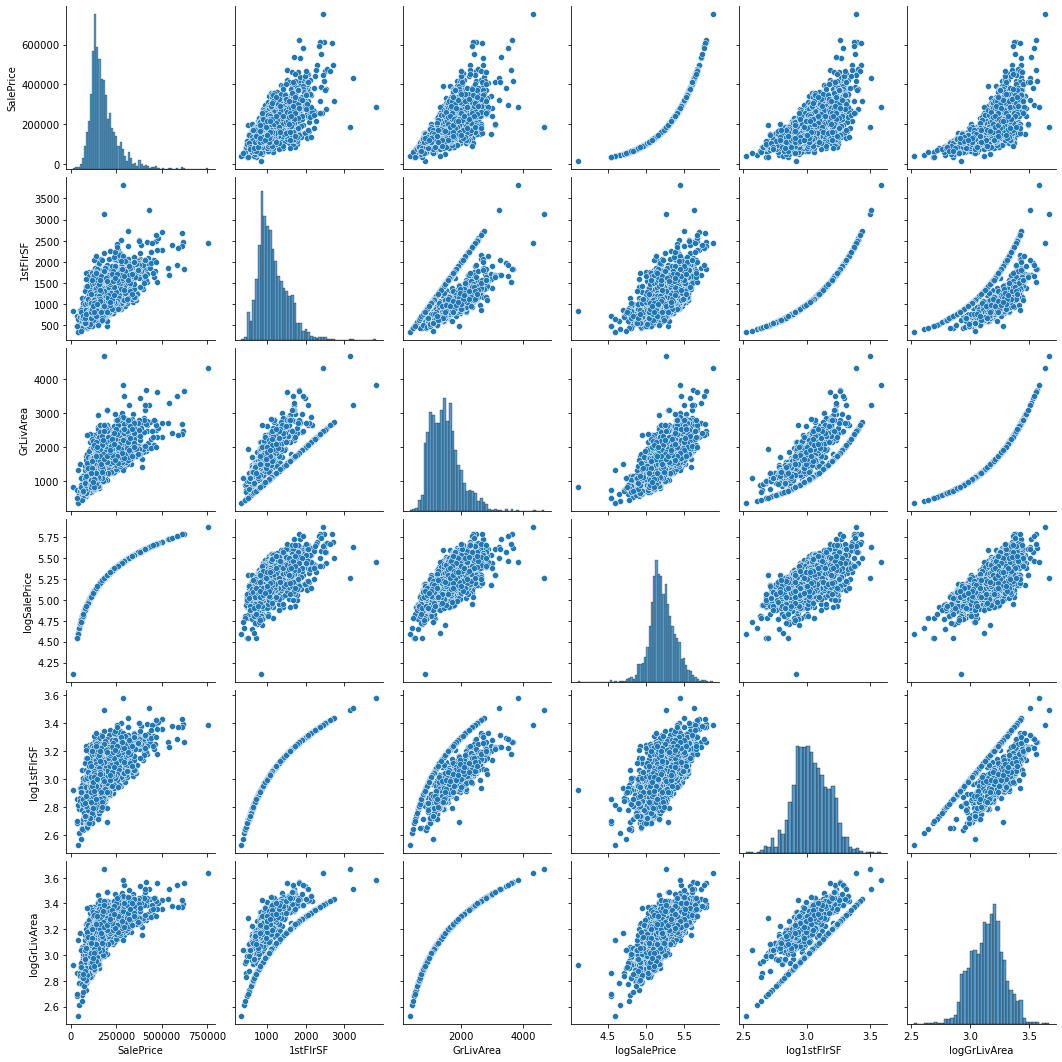

              SalePrice  1stFlrSF  GrLivArea  logSalePrice  log1stFlrSF  \
SalePrice      1.000000  0.642613   0.719981      0.950051     0.611845   
1stFlrSF       0.642613  1.000000   0.539135      0.623993     0.974811   
GrLivArea      0.719981  0.539135   1.000000      0.717711     0.518425   
logSalePrice   0.950051  0.623993   0.717711      1.000000     0.623646   
log1stFlrSF    0.611845  0.974811   0.518425      0.623646     1.000000   
logGrLivArea   0.699264  0.538769   0.973974      0.734913     0.534948   

              logGrLivArea  
SalePrice         0.699264  
1stFlrSF          0.538769  
GrLivArea         0.973974  
logSalePrice      0.734913  
log1stFlrSF       0.534948  
logGrLivArea      1.000000  


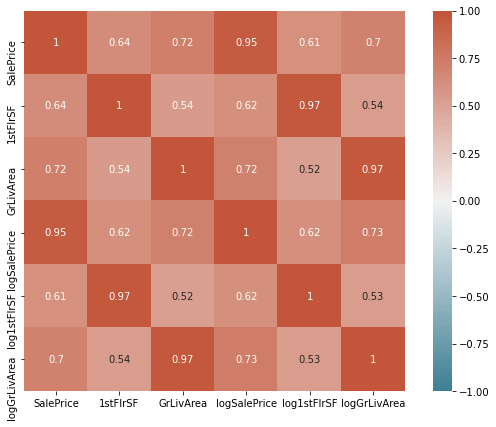

In [28]:
# Other area related stuff, running a grid chart and heat map to investigate the relations in log scale.

df_area = df[["SalePrice", "1stFlrSF", "GrLivArea"]];

df_area["logSalePrice"] = np.log10(df_area["SalePrice"]);
df_area["log1stFlrSF"] = np.log10(df_area["1stFlrSF"]);
df_area["logGrLivArea"] = np.log10(df_area["GrLivArea"]);

plt.figure(figsize=(15,15))
sns.pairplot(df_area);
plt.show()

corr = df_area.corr();
print(corr)
plt.figure(figsize=(10,7))
sns.heatmap(corr, vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(220, 20, n=200), square=True, annot=True);

# Things are not really better on log scale; hence I won't recommend doing so, which reduces the intepretability.

### The room issues

In [66]:
df4 = df.iloc[:, [0] + list(range(8,15))]
EDA_plots(df4)

# number of full bathrooms in basement: maybe positive relations, not very sharp. Cor = 0.29, 42k per bathroom
# number of half bathrooms im basement: really hard to tell, might need to combine with full bathrooms. Cor = -0.33. -10k per room
# number of bathrooms in basement: Cor = 0.53, 73k per bathroom (0 and 4 bathrooms are scarce)
# number of half bathrooms in basement: not sharp. Cor = 0.29. 42kk per half bathroom

# number of bedrooms above ground: peak at 3, correlation = 0.152, 14k per bedroom
# number of kitchen: low correlation: -0.11
# number of rooms above ground: peak at 6, good correlation, but price fell at 12 and above.
# correlation = 0.49, 25k per extra room.

BsmtFullBath


Correlation between BsmtFullBath and sale price is 0.2907552314757222
LinregressResult(slope=42052.88613015417, intercept=159771.50765967715, rvalue=0.29075523147572213, pvalue=1.9272140538164665e-51, stderr=2725.5040429859414, intercept_stderr=1844.7848181074864)
BsmtHalfBath


Correlation between BsmtHalfBath and sale price is -0.03378604992160124
LinregressResult(slope=-10371.335983095209, intercept=178702.80688267256, rvalue=-0.03378604992160123, pvalue=0.0862029245433692, stderr=6042.376924315829, intercept_stderr=1523.4208113818843)
FullBath


Correlation between FullBath and sale price is 0.5349817678925711
LinregressResult(slope=73540.53669528771, intercept=64014.783210137175, rvalue=0.5349817678925711, pvalue=5.288789290127847e-191, stderr=2287.351761830214, intercept_stderr=3760.390420117268)
HalfBath


Correlation between HalfBath and sale price is 0.2858750040157091
LinregressResult(slope=42964.56412507592, intercept=161806.36178834338, rvalue=0.2858750040157091, pvalue=1.024216197694152e-49, stderr=2836.47698729597, intercept_stderr=1776.4773216570156)
BedroomAbvGr


Correlation between BedroomAbvGr and sale price is 0.15180621948840117
LinregressResult(slope=13842.142844332579, intercept=138604.15097782103, rvalue=0.15180621948840117, pvalue=9.043502799990025e-15, stderr=1775.0457729592983, intercept_stderr=5266.100540963906)
KitchenAbvGr


Correlation between KitchenAbvGr and sale price is -0.11397676418120928
LinregressResult(slope=-42220.60989655066, intercept=221982.14921021007, rvalue=-0.11397676418120929, pvalue=6.420379245616552e-09, stderr=7248.152875581852, intercept_stderr=7681.865206531919)
TotRmsAbvGrd


Correlation between TotRmsAbvGrd and sale price is 0.4902194289601559
LinregressResult(slope=23959.113174407958, intercept=25027.75271276405, rvalue=0.4902194289601559, pvalue=4.3844779546310937e-156, stderr=838.9875439341143, intercept_stderr=5511.345229932464)


In [107]:
# Some bathroom things
# PIDs 903230120 and 908154080 had no bathroom

# Here, we are trying to answer the following question:
# How much does a half bathroom count? 0.5? Maybe not...
X = df4.drop("SalePrice", axis = 1);
Y = df4["SalePrice"];
X = sm.add_constant(X);

model = sm.OLS(Y, X);
results = model.fit();
print(results.summary());

# So, a half bathroom in the basement only worthed about 0.4 full bathrooms in the basement
# and a half bathroom over ground is only about 0.3 full bathrooms over ground

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.571
Method:                 Least Squares   F-statistic:                     491.0
Date:                Wed, 18 Aug 2021   Prob (F-statistic):               0.00
Time:                        17:48:31   Log-Likelihood:                -31528.
No. Observations:                2580   AIC:                         6.307e+04
Df Residuals:                    2572   BIC:                         6.312e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         7.349e+04   5952.809     12.345   

In [72]:
# Let's verify this a bit closer.
df4_batheq = df4;
X = df4.drop("SalePrice", axis = 1)
lm.fit(X, df4_batheq["SalePrice"]);
print(lm.score(X, df4_batheq["SalePrice"]));

lm = LinearRegression()

bsmtbath_score = [];
bath_score = [];
half_equiv = np.linspace(0,1,11);
for eq in half_equiv:
    df4_batheq["BsmtEqBath"+"{:.1f}".format(eq)] = df4_batheq["BsmtFullBath"] + eq*df4_batheq["BsmtHalfBath"];
    df4_batheq["EqBath"+"{:.1f}".format(eq)] = df4_batheq["FullBath"] + eq*df4_batheq["HalfBath"];
    
    lm.fit(df4_batheq[["BsmtEqBath"+"{:.1f}".format(eq), "EqBath"+"{:.1f}".format(eq), "KitchenAbvGr", "TotRmsAbvGrd"]], df4_batheq["SalePrice"]);
    print(eq, lm.score(df4_batheq[["BsmtEqBath"+"{:.1f}".format(eq), "EqBath"+"{:.1f}".format(eq), "KitchenAbvGr", "TotRmsAbvGrd"]], df4_batheq["SalePrice"]));

# If we do a multiple linear regression using only # of bathrooms in the basement and over ground with the sale price,
# it still seemed that half bathroom = 0.5 full bathroom makes the best approximation.


# Adding the number of kitchens and other rooms, then it no longer is. (baseline: 0.3--0.5309, 0.4--0.5295, 0.5--0.5261)

0.5719951037020183
0.0 0.520979502271228
0.1 0.5267766376360841
0.2 0.5301077932159673
0.30000000000000004 0.5309472270844604
0.4 0.5294903834929092
0.5 0.5260818026682876
0.6000000000000001 0.5211307476018645
0.7000000000000001 0.5150421170695777
0.8 0.5081741989646109
0.9 0.5008213033669049
1.0 0.4932132131255428
0.5306984775935475


In [82]:
# A grid search on basebent and above ground half bathrooms to see what it is worth.
current_best = 0.0;
best1 = 0;
best2 = 0
for eq1 in half_equiv:
    for eq2 in half_equiv:
        lm.fit(df4_batheq[["BsmtEqBath"+"{:.1f}".format(eq1), "EqBath"+"{:.1f}".format(eq2), "KitchenAbvGr", "TotRmsAbvGrd"]], df4_batheq["SalePrice"]);
        score = lm.score(df4_batheq[["BsmtEqBath"+"{:.1f}".format(eq1), "EqBath"+"{:.1f}".format(eq2), "KitchenAbvGr", "TotRmsAbvGrd"]], df4_batheq["SalePrice"]);
        # print(score);
        
        if score > current_best:
            current_best = score;
            best1 = eq1;
            best2 = eq2;
            
print(best1, best2); # 0.3, 0.3

0.30000000000000004 0.30000000000000004


### The selling condition

In [59]:
df5 = df.iloc[:, [0] + list(range(15,20))]
EDA_plots(df5)

# Functional: seems that the boxplot points to the same average, at least when the fuctionality is Maj1 or better.
# MoSold: Seems that the housing market is the hottest in May-July, when students are in their summer vacation.
# Spring is also pretty good. Correlation seemed low. 0.125
# YrSold: 2010 has the lowest amount of data, probably because the data in year 2010 is not complete.
# correlation seemed to be almost 0: -0.0013

Functional_ord


SaleCondition


SaleType


MoSold


Correlation between MoSold and sale price is 0.012590504982043131
LinregressResult(slope=353.7267205365721, intercept=175883.92971775393, rvalue=0.01259050498204313, pvalue=0.5226708731683407, stderr=553.2849242933162, intercept_stderr=3709.965324460159)
YrSold


Correlation between YrSold and sale price is -0.001375693503362654
LinregressResult(slope=-78.65364077536265, intercept=335983.42130940757, rvalue=-0.0013756935033626535, pvalue=0.9443188332147469, stderr=1126.0437814180164, intercept_stderr=2260914.395731213)


In [93]:
temp = housing[(housing["YrSold"]<= 2009) & (housing["YrSold"] >= 2006)]
temp["MoSold"].value_counts()

7     392
6     384
5     290
8     193
4     186
3     163
10    148
9     131
11    117
2      95
12     86
1      80
Name: MoSold, dtype: int64

In [45]:
EDA_plots(df2)

MSSubClass


Correlation between MSSubClass and sale price is -0.08458728424971684
LinregressResult(slope=-148.27953242292256, intercept=186614.14535018988, rvalue=-0.08458728424971687, pvalue=1.691633281160867e-05, stderr=34.40134274796607, intercept_stderr=2471.0752580422445)
BldgType


HouseStyle


## MSSubClass vs BldgType vs HouseStyle: Dealing with conflicts
`           MSSubClass      BldgType HouseStyle    Conflict       Union
1-Story    020 030 040 120          1Story        1237;   ; 1288 1295
1.5-Story  045 050 150              1.5Fin 1.5Unf 277 ;   ; 303  307
2-Story    060 070 160              2Story        738 ;   ; 773  781
2.5-Story  075                      2.5Fin 2.5Unf 21  ;   ; 28   29
SplitMulti 080 180                  SLvl          124 ;   ; 118  128
2FamConv   190             2FmCon                 53  ; 54;      55
SptFoyer   085                      SFoyer        43  ;   ; 70   70
Duplex     090             Duplx                  87  ; 87
Unfinished 045
PUD        120 150 160 180
1Fam                       1Fam
TwnhsE                     TwnhsE
TwnhsI                     TwnhsI`

In [88]:
print("1 Story Stuff:  ", sum(df.apply(lambda x: x["MSSubClass"] in [20, 30, 40, 120], axis=1) | df.apply(lambda x: x["HouseStyle"] == "1Story", axis=1))); # 1295
print("1.5 Story Stuff:", sum(df.apply(lambda x: x["MSSubClass"] in [45, 50, 150], axis=1) | df.apply(lambda x: x["HouseStyle"] in ["1.5Fin", "1.5Unf"], axis=1)));
print("2 Story Stuff:  ", sum(df.apply(lambda x: x["MSSubClass"] in [60, 70, 160], axis=1) | df.apply(lambda x: x["HouseStyle"] == "2Story", axis=1)));
print("2.5 Story Stuff:", sum(df.apply(lambda x: x["MSSubClass"] == 75, axis=1) | df.apply(lambda x: x["HouseStyle"] in ["2.5Fin", "2.5Unf"], axis=1)));
print("Split/Multilvl: ", sum(df.apply(lambda x: x["MSSubClass"] in [80, 180], axis=1) | df.apply(lambda x: x["HouseStyle"] == "SLvl", axis=1)));
print("Split Foyer:    ", sum(df.apply(lambda x: x["MSSubClass"] ==85, axis=1) | df.apply(lambda x: x["HouseStyle"] == "SFoyer", axis=1)));
print("Unfinished:     ", sum(df.apply(lambda x: x["MSSubClass"] ==45, axis=1) | df.apply(lambda x: x["HouseStyle"] in ["1.5Unf", "2.5Unf"], axis=1)));
print("\n");

print("2 Family Conv:  ", sum(df.apply(lambda x: x["MSSubClass"] == 190, axis=1) | df.apply(lambda x: x["BldgType"] == "2fmCon", axis=1)));


1 Story Stuff:   1295
1.5 Story Stuff: 307
2 Story Stuff:   781
2.5 Story Stuff: 29
Split/Multilvl:  128
Split Foyer:     70
Unfinished:      42


2 Family Conv:   55


In [89]:
# Let's investigate a bit on where the conflicts are from.
mask_1story = df.apply(lambda x: x["MSSubClass"] in [20, 30, 40, 120], axis=1) & ~df.apply(lambda x: x["HouseStyle"] == "1Story", axis=1);
print((df[mask_1story])["HouseStyle"]); # SFoyer 2; 1.5 Story 4; 2 Story 1

mask_1_5story = df.apply(lambda x: x["MSSubClass"] in [45, 50, 150], axis=1) & ~df.apply(lambda x: x["HouseStyle"] in ["1.5Fin", "1.5Unf"], axis=1);
print((df[mask_1_5story])["HouseStyle"]); # 2 Story 4

mask_2story = df.apply(lambda x: x["MSSubClass"] in [60, 70, 160], axis=1) & ~df.apply(lambda x: x["HouseStyle"] == "2Story", axis=1);
print((df[mask_2story])["HouseStyle"]); # 2.5 Story 4; 1.5 Story 2; SLvl 2

mask_2_5story = df.apply(lambda x: x["MSSubClass"] == 75, axis=1) & ~df.apply(lambda x: x["HouseStyle"] in ["2.5Fin", "2.5Unf"], axis=1);
print((df[mask_2_5story])["HouseStyle"]); # 2 Story 1

mask_split_multi = df.apply(lambda x: x["MSSubClass"] in [80, 180], axis=1) & ~df.apply(lambda x: x["HouseStyle"] == "SLvl", axis=1);
print((df[mask_split_multi])["HouseStyle"]); # SFoyer 10, and all from Multilevel (180)

mask_2FamConv = df.apply(lambda x: x["MSSubClass"] == 190, axis=1) & ~df.apply(lambda x: x["BldgType"] == "2fmCon", axis=1);
print((df[mask_2FamConv])["BldgType"]); # BldgType = 1Fam
mask_2FamConv_r = ~df.apply(lambda x: x["MSSubClass"] == 190, axis=1) & df.apply(lambda x: x["BldgType"] == "2fmCon", axis=1);
print((df[mask_2FamConv_r])["MSSubClass"]); # MSSubClass = 1Story, 2Story

mask_unfinished = df.apply(lambda x: x["MSSubClass"] ==45, axis=1) & ~df.apply(lambda x: x["HouseStyle"] in ["1.5Unf", "2.5Unf"], axis=1);
print((df[mask_unfinished])["HouseStyle"]); # 1.5Fin

779     SFoyer
1073    1.5Fin
1093    SFoyer
1126    1.5Fin
1409    2Story
2272    1.5Fin
2575    1.5Unf
Name: HouseStyle, dtype: object
49      2Story
634     2Story
1394    2Story
2069    2Story
Name: HouseStyle, dtype: object
531     2.5Unf
568     2.5Unf
1437    1.5Fin
1956    2.5Fin
2005      SLvl
2179    2.5Unf
2545    1.5Fin
2560      SLvl
Name: HouseStyle, dtype: object
833    2Story
Name: HouseStyle, dtype: object
9       SFoyer
97      SFoyer
106     SFoyer
107     SFoyer
794     SFoyer
846     SFoyer
1523    SFoyer
1873    SFoyer
2256    SFoyer
2420    SFoyer
Name: HouseStyle, dtype: object
653    1Fam
Name: BldgType, dtype: object
6      20
531    60
Name: MSSubClass, dtype: int64
1983    1.5Fin
Name: HouseStyle, dtype: object


## Matt's legacy

In [9]:


### Currently does not work for some reason

import numpy as np
import pandas as pd
import plotly.express as px
from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm as anova

def EDA_plots_v2(df, features = df.columns, targets = ['SalePrice']):
    # can pass features = [list of features] and targets = [list of targets]
    # to get plots and regressions of different variables
    for feature in features:
        for target in targets:
            if feature != target and feature != 'PID':
                print('feature: ',feature)
                scatter = px.scatter(x = df[f'{feature}'], y = df[f'{target}'])
                scatter.update_layout(
                    title={
                        'text': f'Scatterplot, {feature} vs {target}',
                        'y':0.95,
                        'x':0.5,
                        'xanchor': 'center',
                        'yanchor': 'top'},
                    xaxis_title = f'{feature}',
                    yaxis_title = f'{target}'
                )
                scatter.show()
                hist = px.histogram(x = df[f'{feature}'])
                hist.update_layout(
                    title={
                        'text': f'Distribution of {feature}',
                        'y':0.95,
                        'x':0.5,
                        'xanchor': 'center',
                        'yanchor': 'top'},
                    xaxis_title = f'{feature}',
                    yaxis_title = 'Frequency'
                )
                hist.show()
                box = px.box(x = df[f'{feature}'], y = df[f'{target}'])
                box.update_layout(
                    title={
                        'text': f'Boxplot, {feature} vs {target}',
                        'y':0.95,
                        'x':0.5,
                        'xanchor': 'center',
                        'yanchor': 'top'},
                    xaxis_title = f'{feature}',
                    yaxis_title = 'Frequency'
                )
                box.show()
                temp = df[df[f'{feature}'].isna() == False].reset_index(drop = True)
                if type(temp.loc[0, f'{feature}']) != str:
                    price_corr = temp[f'{feature}'].corr(temp[f'{target}'])
                    print(f'Correlation between {feature} and {target} is {price_corr}')
                    linreg = stats.linregress(temp[f'{feature}'], temp[f'{target}'] )
                    print(linreg)
                    print('r^2 = ',linreg.rvalue**2)
                if type(temp.loc[0, f'{feature}']) == str:
                    # this is to see full multiple regression on each value of categorical variable
                    # can comment this out
                    fit = ols(f'{target} ~ C({feature})', data=temp).fit()
                    print(fit.summary())
                    # this is to see anova on whether any value of categorical variable is significantly different
                    #anova_table = anova(fit, typ=2)
                    #print(anova_table)
            print()

In [8]:
def EDA_plots(df):
    for feature in df.columns:
        if feature != 'SalePrice':
            print(feature)
            scatter = px.scatter(x = df[f'{feature}'], y = df['SalePrice'])
            scatter.update_layout(
                title={
                    'text': f'Scatterplot, {feature} vs SalePrice',
                    'y':0.95,
                    'x':0.5,
                    'xanchor': 'center',
                    'yanchor': 'top'},
                xaxis_title = f'{feature}',
                yaxis_title = 'SalePrice'
            )
            scatter.show()
            hist = px.histogram(x = df[f'{feature}'])
            hist.update_layout(
                title={
                    'text': f'Distribution of {feature}',
                    'y':0.95,
                    'x':0.5,
                    'xanchor': 'center',
                    'yanchor': 'top'},
                xaxis_title = f'{feature}',
                yaxis_title = 'Frequency'
            )
            hist.show()
            box = px.box(x = df[f'{feature}'], y = df['SalePrice'])
            box.update_layout(
                title={
                    'text': f'Boxplot, {feature} vs SalePrice',
                    'y':0.95,
                    'x':0.5,
                    'xanchor': 'center',
                    'yanchor': 'top'},
                xaxis_title = f'{feature}',
                yaxis_title = 'Frequency'
            )
            box.show()
            if type(df.loc[0, f'{feature}']) != str:
                price_corr = df[f'{feature}'].corr(df['SalePrice'])
                print(f'Correlation between {feature} and sale price is {price_corr}')
                temp = df[df[f'{feature}'].isna() == False]
                linreg = stats.linregress(temp[f'{feature}'], temp['SalePrice'] )
                print(linreg)
                linreg.rvalue**2